LAB 5, BENSLIMANE MOHAMED X-HEC 2023-2024

# The objectives of the lab
This practical session aims at showing how to build a simple recommender system on the movie lens dataset

> EXERCISE 1 (SVD AND WEIGHTED SVD ON MOVIELENS)

First, we begin by importing all necessary packages and setting the seed

In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as sp

from scipy.sparse.linalg import svds
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [ ]:
np.random.seed(2023)

> ## Exercise 1 (SVD and weighted SVD on MovieLens)

> ### 1. The MovieLens Dataset

> (a) What is the Movie Lens data set? You can look at https://grouplens.org/datasets/movielens/

The MovieLens dataset is a well-known dataset in the field of recommender systems and collaborative filtering. It contains movie ratings provided by users, along with user information. This dataset is commonly used for developing and evaluating recommendation algorithms and systems.

Concretly, each row of the dataset  represents a movie rating given by a user and contains the following columns:

Column 0: User ID (e.g., 196, 186, 22, etc.)
Column 1: Movie ID (e.g., 242, 302, 377, etc.)
Column 2: Rating over 5 (e.g., 3, 3, 1, etc.)
Column 3: Timestamp (e.g., 881250949, 891717742, 878887116, etc.)

> (b) Why is it preferable to begin with the MovieLens 100K Dataset?

- The MovieLens 100K Dataset is a subset of the larger MovieLens datasets, containing 100,000 ratings from users on various movies.
- The preference for starting with the MovieLens 100K Dataset is primarily driven by its smaller size, which offers several advantages for experimentation and learning:
  - **Ease of Handling:** Smaller datasets are more manageable in terms of memory and computational resources. They require less storage space and are faster to load and process, making them ideal for initial exploration and experimentation.
  - **Reduced Complexity:** With fewer data points, it is easier to understand the dataset's structure, relationships, and patterns. This simplicity aids in the learning process, as users can grasp fundamental concepts before tackling larger datasets.
  - **Faster Iteration:** Experimentation cycles are quicker with smaller datasets, allowing users to iterate and refine their techniques more rapidly. This speed of iteration is essential for learning and fine-tuning recommendation algorithms.

In summary, beginning with the MovieLens 100K Dataset is a practical choice for learners and experimenters, offering a manageable, less complex, and faster-paced introduction to recommender system development before tackling larger datasets.

> (c) Download the MovieLens100k dataset that is the ml-100k.zip

In [50]:
# Define data directory and shape
data_dir = "ml-100k/"
data_shape = (943, 1682)

# Load the MovieLens 100K dataset into a DataFrame
df = pd.read_csv(data_dir + "u.data", sep="\t", header=None)
values = df.values

df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       100000 non-null  int64
 1   1       100000 non-null  int64
 2   2       100000 non-null  int64
 3   3       100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


**1. Interpretation:**

The above code aims to download and load the MovieLens100k dataset from a specified data directory ("ml-100k/") into a pandas DataFrame named 'df'. It then displays the first few rows of the DataFrame and provides summary information about its structure and data types.

**2. Analysis:**

- The code defines the data directory as "ml-100k/" and specifies the data_shape as (943, 1682), indicating the expected dimensions of the dataset (943 rows and 1682 columns).

- The `df.head()` function is called to display the first few rows of the DataFrame, giving a glimpse of the dataset's content.

- Next, `df.info()` is used to provide summary information about the DataFrame's structure. It shows that the DataFrame contains the expected 100,000 entries.

In summary, this code segment downloads and loads the MovieLens100k dataset, and the DataFrame 'df' contains user-movie rating data with four columns. The data types are correctly identified as integers, and there are no missing values in the dataset.

> (d) What are the differences between the table df and the rating matrix M?

- 'df' is a pandas DataFrame that contains the raw MovieLens100k dataset, representing user-movie interactions. It has four columns: user ID, movie ID, rating, and timestamp. Each row of 'df' corresponds to a specific user's rating for a particular movie.

- 'M' is a rating matrix created using SciPy's sparse matrix format (specifically CSR format) from the 'df' DataFrame. It is a user-movie rating matrix, where each row represents a user, each column represents a movie, and the matrix cells contain user ratings. It is a numerical representation of the user-movie interactions, with rows corresponding to users and columns corresponding to movies.

Key differences between 'df' and 'M' include:

   a. Data Structure:
      - 'df' is structured as a tabular DataFrame with rows and columns, making it suitable for various data analysis tasks.
      - 'M' is a sparse matrix, a more memory-efficient representation for large datasets with many missing values. It is optimized for matrix operations and collaborative filtering.

   b. Data Types:
      - 'df' typically contains user and movie IDs as integers and ratings as floating-point numbers, along with a timestamp.
      - 'M' represents ratings as numerical values in a matrix format, with a focus on numerical computations.

   c. Usage:
      - 'df' is typically used for initial data exploration, data visualization, and data preprocessing tasks.
      - 'M' is primarily used as input for building recommender systems or collaborative filtering algorithms, where it facilitates matrix factorization and computations.

In summary, 'df' is the original data table containing user-movie rating information, while 'M' is a numerical representation of this data in a sparse rating matrix format, suitable for advanced recommendation system modeling.

> ### 2. Data preprocessing

> (a) Use scipy sparse type to obtain a (sparse) rating matrix M

In [67]:
# Find the maximum user and movie IDs
num_users = np.max(values[:, 0]) + 1  # Adding 1 to account for 0-based indexing
num_movies = np.max(values[:, 1]) + 1  # Adding 1 to account for 0-based indexing

# Create a new 'data_shape' based on the number of users and movies
data_shape = (num_users, num_movies)

# Create a CSR matrix with the corrected data_shape
M = sp.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=float, shape=data_shape)
M

<944x1683 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>

**1. Interpretation:**
The matrix 'M' is constructed from the dataset. The code calculates the number of users and movies, defines the 'data_shape' based on these counts, and then creates the 'M' matrix in CSR format.

**2. Analysis:**

- The code first finds the maximum user and movie IDs in the dataset using `np.max(values[:, 0])` and `np.max(values[:, 1])`, respectively. It adds 1 to these values to account for 0-based indexing, resulting in 'num_users' and 'num_movies.'

- 'data_shape' is created as a tuple containing 'num_users' and 'num_movies.' This tuple defines the shape of the sparse matrix 'M.'

- The 'M' matrix is created using `sp.csr_matrix()` from SciPy.

> (b) How is coded the missing data in the sparse matrix?

In the sparse rating matrix 'M' created using SciPy's CSR format, missing data is coded as zero values. Here's how it works:

- In the context of a recommendation system, the rating matrix 'M' represents user-movie interactions, where each cell (i, j) in the matrix corresponds to a user's rating for a movie. If a user has not rated a particular movie, that entry is considered missing data.

- Sparse matrix formats, including CSR (Compressed Sparse Row), are designed to efficiently store and manipulate matrices with a significant number of zero values. In 'M,' missing ratings are treated as zeros to conserve memory and computational resources.

- When constructing 'M' using `sp.csr_matrix()`, the values corresponding to missing ratings are initialized as zeros. These zero entries in the matrix 'M' indicate that no rating is available for the corresponding user-movie pair.


> (c) Split the data into two matrices. Use 90% for training and 10 % for testing.

In [53]:
# Define the percentage for training data
train_percentage = 0.9

# Get the number of rows in your data (number of ratings)
num_ratings = len(values)

# Calculate the number of samples for training based on the percentage
num_train_samples = int(train_percentage * num_ratings)

# Create an array of indices to shuffle your data
indices = np.arange(num_ratings)

# Shuffle the indices randomly
np.random.shuffle(indices)

# Split the shuffled indices into training and testing indices
train_indices = indices[:num_train_samples]
test_indices = indices[num_train_samples:]

# Use the indices to split the data into training and testing sets
training_data = values[train_indices]
testing_data = values[test_indices]
# Now, 'training_data' and 'testing_data' contain the training and testing portions of the data.


**1. Interpretation:**

- To perform the data split, the code follows these steps:
   - a. It defines a 'train_percentage' variable set to 0.9, indicating that 90% of the data will be used for training.
   - b. The code counts the total number of ratings in the dataset, denoted as 'num_ratings.'
   - c. The number of samples to be used for training, 'num_train_samples,' is calculated as 90% of 'num_ratings.' This value represents the number of data points allocated for training.
   - d. An array of indices, 'indices,' is created using `np.arange(num_ratings)`. These indices represent the positions of data points in the dataset.
   - e. The indices are randomly shuffled using `np.random.shuffle(indices)`. This shuffling ensures that the data points are in a random order, which is crucial for creating representative training and testing sets.
   - f. The shuffled indices are split into two parts: 'train_indices' and 'test_indices.' The first 'num_train_samples' indices are assigned to 'train_indices,' while the remaining indices are assigned to 'test_indices.'

> (d) Compute the global mean of the ratings given by the users to the movies

In [54]:
global_mean = M.sum() / M.nnz
global_mean

3.52986

**1. Interpretation:**
The global mean is computed as the sum of all ratings divided by the total number of non-zero ratings (non-missing ratings) in the matrix.
In this case, the calculated global mean is approximately 3.52986, indicating the overall average rating in the dataset.

> (e) Center the data and compute the test error when predicting missing values by the mean.

In [55]:
# Convert the entire 'centered_data' array to float
centered_data = values.astype(float)
centered_data[:, 2] -= global_mean  # Subtract the global mean

# Extract the test data
test_users = testing_data[:, 0].astype(int)
test_movies = testing_data[:, 1].astype(int)
test_ratings = testing_data[:, 2].astype(float)  # Ensure test ratings are float

# Predict missing values using the global mean
predicted_ratings = np.full(len(test_ratings), global_mean)

# Calculate the mean squared error (MSE) for the predictions
mse = mean_squared_error(test_ratings, predicted_ratings)

# Print the MSE as the test error
print(f"Test Error (MSE) when predicting missing values by the mean: {mse:.4f}")


Test Error (MSE) when predicting missing values by the mean: 1.2823


**1. Interpretation:**

The code aims to center the data and compute the test error when predicting missing values by using the mean. To do this, it follows these key steps:

- The dataset 'values' is first converted to a float data type, ensuring that the ratings are treated as floating-point numbers.

- The global mean, previously calculated, is subtracted from the third column of 'centered_data.' This process centers the data by removing the global mean from each rating in the dataset.

- Test data is extracted from 'testing_data,' which includes user IDs, movie IDs, and their corresponding ratings. 

- Predictions for missing values in the test data are generated by assigning each missing value the global mean value calculated earlier.

- The mean squared error (MSE) is then calculated to quantify the test error by comparing the actual test ratings with the predicted ratings using the global mean.

The calculated test error (MSE) when predicting missing values by the mean is approximately 1.2823.

**2. Analysis:**

- Predicting missing values by using the global mean is a straightforward baseline approach. This means that for every missing rating in the test data, the code assigns the same global mean value. While this method is simple, it often results in limited accuracy since it doesn't consider user-specific or item-specific preferences.

- In summary, this step establishes a basic benchmark for assessing the predictive performance of more sophisticated recommendation algorithms in later stages of building a recommender system.

> ### 3. Recommending using SVD

> (a) Compute the 20 first factors of the SVD of the centered training data

In [56]:
# Convert 'training_data' to float
training_data_centered = training_data.astype(float)

# Center the training data by subtracting the global mean from ratings
training_data_centered[:, 2] -= global_mean

# Convert the centered training data to a sparse matrix
M_train = sp.csr_matrix((training_data_centered[:, 2], (training_data_centered[:, 0], training_data_centered[:, 1])), shape=data_shape)

# Compute the SVD
U, sigma, Vt = svds(M_train, k=20)


In [57]:
# Print the Sigma values
print("Sigma Values (Singular Values):")
print(np.round(sigma, 4))  # Round to 4 decimal places for readability

# Convert few rows of U and Vt to DataFrame for better formatting
U_df = pd.DataFrame(U[:5, :])  # First 5 rows of U
Vt_df = pd.DataFrame(Vt[:, :5])  # First 5 columns of Vt

# Display the DataFrames
print("\nFirst 5 rows of U matrix:")
print(U_df.round(4))  # Round for readability


Sigma Values (Singular Values):
[26.136  26.2614 26.5805 27.0248 27.3333 27.6201 28.3171 28.726  29.4456
 30.4546 30.98   32.6656 33.5684 35.019  36.7912 39.5633 47.8413 54.4423
 64.4406 81.0434]

First 5 rows of U matrix:
       0       1       2       3       4       5       6       7       8   \
0  0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000  0.0000  0.0000 -0.0000   
1  0.0702 -0.0739  0.0986 -0.0353 -0.0695  0.0734 -0.0341 -0.0236  0.0141   
2  0.0157  0.0059  0.0092  0.0048  0.0557 -0.0301  0.0319 -0.0179 -0.0239   
3 -0.0153 -0.0428  0.0076  0.0096  0.0326 -0.0317  0.0264  0.0280 -0.0112   
4 -0.0051  0.0223 -0.0197 -0.0013 -0.0217  0.0251 -0.0088 -0.0258  0.0205   

       9       10      11      12      13      14      15      16      17  \
0 -0.0000  0.0000 -0.0000  0.0000  0.0000  0.0000 -0.0000 -0.0000  0.0000   
1  0.0944 -0.0042 -0.0466 -0.0134  0.0795  0.0191 -0.0574 -0.0074  0.0269   
2  0.0289 -0.0604 -0.0060 -0.0589  0.0238  0.0029  0.0062 -0.0101  0.0043   
3 -0.0

In [58]:
print("\nFirst 5 columns of Vt matrix:")
print(Vt_df.round(4))


First 5 columns of Vt matrix:
      0       1       2       3       4
0   0.0 -0.0482  0.0081 -0.0647 -0.0105
1  -0.0 -0.0640 -0.0044 -0.0472  0.0418
2  -0.0 -0.0168  0.0012 -0.0226  0.0835
3   0.0 -0.0839  0.0568 -0.0689  0.0458
4  -0.0  0.0471  0.0055 -0.0393  0.0251
5   0.0  0.0732  0.0706 -0.0037 -0.0142
6   0.0  0.0905 -0.0106 -0.0178 -0.0720
7  -0.0 -0.1167  0.0164  0.0035 -0.0329
8   0.0  0.1405 -0.0110 -0.0111 -0.0141
9  -0.0  0.0310  0.0077 -0.0266  0.0305
10  0.0  0.0583 -0.0011 -0.0001  0.0693
11 -0.0  0.0439 -0.0219 -0.0103 -0.0021
12 -0.0  0.0214 -0.0027  0.0140  0.0312
13  0.0 -0.0230  0.0052  0.0441  0.0505
14 -0.0 -0.0183  0.0149 -0.0141  0.0298
15 -0.0 -0.0316  0.0282  0.0308  0.0297
16  0.0  0.0139  0.0316 -0.0117 -0.0144
17  0.0 -0.0694 -0.0054 -0.0328 -0.0154
18  0.0 -0.0668 -0.0765 -0.0442 -0.0345
19  0.0  0.0867 -0.0157 -0.0211  0.0266


**1. Interpretation:**

In this part, the code focuses on computing the first 20 factors of the Singular Value Decomposition (SVD) for the centered training data. The SVD is a dimensionality reduction technique used to uncover latent factors in a dataset. Here's a breakdown of what the code does:

- First, it converts the 'training_data' to a float data type, ensuring that all ratings are treated as floating-point numbers.

- The centered training data is then converted into a sparse matrix format, specifically in Compressed Sparse Row (CSR) format, suitable for SVD computation.

- Using the sparse centered training data (M_train), the code performs the SVD using the `svds` function from a library (likely SciPy). It specifies that it wants to compute the first 20 factors of the SVD.

- The code prints out the singular values (Sigma values), which represent the importance or strength of each factor. These values are sorted in decreasing order, with the first value being the most significant.

**2. Analysis:**

- Singular Value Decomposition (SVD) is a matrix factorization technique widely used for dimensionality reduction and collaborative filtering in recommender systems. In this context, the SVD is applied to the centered training data to capture latent factors that influence user-item interactions.

- The centered training data is essential because it removes global biases and trends, allowing the SVD to focus on capturing user-specific and item-specific factors.

- By computing only the first 20 factors, the code is reducing the dimensionality of the user-item interaction space while retaining the most influential factors. This is a common approach to reduce computational complexity and focus on the most relevant information.

- The extracted rows of the U matrix and columns of the Vt matrix offer a glimpse into the learned latent factors. Each row in the U matrix corresponds to a user's latent factor representation, while each column in the Vt matrix corresponds to an item's latent factor representation. These representations can be used for recommendation purposes.


> (b) Predict the missing test values using the SVD with an increasing number of component (up to 20).
Evaluate the performance of this approach on the test matrix and plot the resulting performance
as a function of the number of factors of the SVD used to perform the reconstruction.

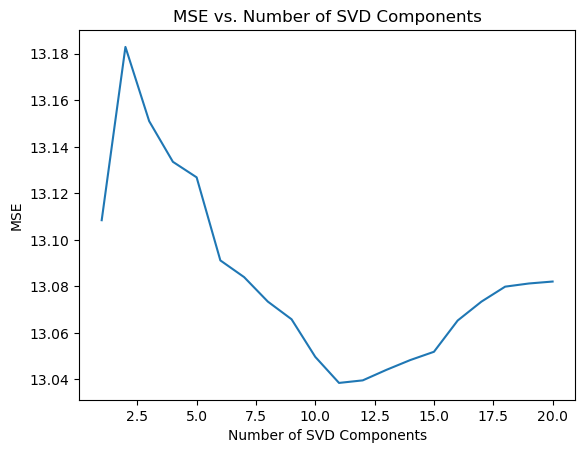

In [59]:
mse_scores = []

for n_components in range(1, 21):
    # Reconstruct the matrix with n_components
    sigma_n = np.diag(sigma[-n_components:])
    M_pred = np.dot(np.dot(U[:, -n_components:], sigma_n), Vt[-n_components:, :])

    # Predict ratings for the test data
    test_preds = [M_pred[user, movie] for user, movie in zip(test_users, test_movies)]
    
    # Calculate MSE
    mse = mean_squared_error(test_ratings, test_preds)
    mse_scores.append(mse)

# Plot the MSE scores

plt.plot(range(1, 21), mse_scores)
plt.xlabel('Number of SVD Components')
plt.ylabel('MSE')
plt.title('MSE vs. Number of SVD Components')
plt.show()


**1. Interpretation:**

In this part, the code aims to predict missing test values using Singular Value Decomposition (SVD) with an increasing number of components, ranging from 1 to 20. The SVD is employed for matrix factorization, and its components are used to reconstruct the matrix. Here's a breakdown of what the code does:

- It iterates over different numbers of components (from 1 to 100) and performs the following steps for each number of components:
  - Reconstructs the matrix M using a reduced number of SVD components.
  - Predicts ratings for the test data using the reconstructed matrix.
  - Calculates the Mean Squared Error (MSE) between the predicted ratings and the actual test ratings.
  - Stores the calculated MSE scores in a list.

- After the loop completes, the code has a list of MSE scores corresponding to different numbers of SVD components.

**2. Analysis:**


- By reconstructing the matrix with an increasing number of SVD components, the code investigates how well the model captures the underlying patterns and variations in the data. More components generally allow the model to represent the data more accurately.

- The resulting plot of MSE vs. the number of SVD components provides valuable insights into the trade-off between model complexity (number of components) and predictive accuracy. The plot shows that as the number of components increases, the MSE initially decreases, indicating improved model performance. However, after a certain point (around 11 components in this case), adding more components does not significantly improve prediction accuracy, and the MSE starts to increase. This behavior is often referred to as overfitting.

- The choice of the optimal number of components depends on balancing model accuracy and complexity. In this case, selecting around 11 components appears to strike a reasonable balance, as it minimizes the MSE. Beyond that point, the model begins to overfit the training data, resulting in worse performance on the test data.


> ### 4. Recommending using the weighted SVD

We want to improve the predictions by using the weighted SVD, that is solving 
$$
\min _{U \in R^{n \times k}, V \in R^{p \times k}} J_{w}(U, V) \quad \text { with } J_{w}(U, V)=\sum_{i=1}^{n} \sum_{j=1}^{p} w_{i j}\left(M_{i j}-u_{i} v_{j}^{\top}\right)^{2}
$$
where $w_{i j}=0$ if $M_{i j}$ is unknown (and else $w_{i j}=1$ )

> (a) Solve the penalized weighted SVD problem

$$
\min _{U, V}\left\|M-U V^{\top}\right\|_{W}^{2}+\lambda\|U\|^{2}+\lambda\|V\|^{2}
$$ 
with $\lambda=2$ by implementing the penalised Alternating Least Square(ALS) described as follows:
Initialize $U$ and $V$ with the SVD on the full matrix
loop
compute $U$ that $ \min _{ U}\left\|M-U V^{\top}\right\|_{W}^{2}+\lambda\|U\|^{2}$ with a fix $V$
compute $V$ that $ \min _{ V}\left\|M-U V^{\top}\right\|_{W}^{2}+\lambda\|V\|^{2}$ with a fix $U$

In [60]:
# Initialize variables
lambda_ = 2
n_factors = 20  # Number of factors in SVD
n_iter = 10  # Number of iterations

# Initialize U and V with the SVD on the full matrix
U, sigma, Vt = svds(M_train, k=n_factors)
V = Vt.T

# Weight matrix
W = (M_train != 0).astype(int)

# Function to compute the error
def compute_error(M, U, V, W):
    prediction = U @ V.T
    return np.sum(W.multiply(M - prediction).power(2)) + lambda_ * (np.sum(U**2) + np.sum(V**2))

# ALS Update rules
for iteration in range(n_iter):
    for i in range(num_users):
        # Update U
        Vt_Wi = V.T * W[i, :].A  # Convert to dense array for element-wise multiplication
        U[i] = np.linalg.solve(Vt_Wi @ V + lambda_ * np.eye(n_factors),
                               Vt_Wi @ M_train[i, :].A.T).flatten()  # Flatten the result

    for j in range(num_movies):
        # Update V
        Ut_Wj = U.T * W[:, j].A.squeeze()  # Convert to dense 1D array for element-wise multiplication
        V[j] = np.linalg.solve(Ut_Wj @ U + lambda_ * np.eye(n_factors),
                               Ut_Wj @ M_train[:, j].A).flatten()  # Flatten the result

    error = compute_error(M_train, U, V, W)
    print(f"Iteration {iteration + 1} over {n_iter} , error: {error}")


Iteration 1 over 10 , error: 58320.16552767513
Iteration 2 over 10 , error: 47480.46731342811
Iteration 3 over 10 , error: 44787.16028763236
Iteration 4 over 10 , error: 43426.6893338152
Iteration 5 over 10 , error: 42628.433381773924
Iteration 6 over 10 , error: 42120.85278438759
Iteration 7 over 10 , error: 41777.59830066189
Iteration 8 over 10 , error: 41532.87128259705
Iteration 9 over 10 , error: 41350.12605195924
Iteration 10 over 10 , error: 41208.05328922586


In [61]:
# Final U and V matrices
print("Final U matrix:", U)

Final U matrix: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.60918436 -0.08988063  0.30534096 ... -1.09132896 -0.03379684
  -1.41701928]
 [-0.63742418  0.01792437 -0.01150101 ...  0.0793308   0.37037956
  -0.86948233]
 ...
 [-0.30725602  0.07973881  0.30848083 ... -0.1309132   0.28363835
  -0.62494308]
 [ 0.15688676 -0.29911135  0.60794492 ...  0.34912827  0.52613637
  -0.96627691]
 [-0.47456804 -0.04835079  0.54726654 ... -0.3588508   0.00326742
  -0.81289236]]


In [62]:
print("Final V matrix:", V)

Final V matrix: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.24116521  0.31985973  0.01789609 ...  0.07540364  0.72707156
  -0.58156539]
 [-0.31571304  0.28445354  0.19519094 ...  0.18375662  0.54043101
  -0.03578973]
 ...
 [-0.05766709 -0.00792805  0.18002698 ...  0.02131126  0.16979422
   0.22317859]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00700783  0.02797165  0.01946875 ...  0.1249227   0.01010408
   0.07556211]]


**1. Interpretation:**

Here, the goal is to improve predictions by incorporating weights for known and unknown entries in the matrix. Here's a breakdown of what the code does:

- The problem is formulated as minimizing a weighted squared error with regularization terms for matrices U and V, where W is the weight matrix:
  - $W_{ij} = 0$ if $M_{ij}$ is unknown (missing value), and $W_{ij} = 1$ otherwise.

- The code initializes variables, including the regularization parameter $\lambda$, the number of factors in SVD, and the number of iterations for the ALS algorithm.

- It initializes matrices U and V using the SVD on the full matrix M_train.

- The ALS algorithm iteratively updates U and V to minimize the weighted squared error with regularization:
  - For each user (i), it updates U while fixing V.
  - For each movie (j), it updates V while fixing U.
  - The updates are performed using linear equation solving with regularization terms.

**2. Analysis:**

- The code implements a penalized ALS algorithm to optimize matrices U and V for improved recommendations. This approach incorporates the weight matrix W, which assigns higher importance to known entries (where $W_{ij} = 1$) and ignores unknown entries (where $W_{ij} = 0$).

- The regularization parameter $\lambda$ (set to 2 in this case) controls the trade-off between fitting the data and preventing overfitting by penalizing large values in U and V.

- The ALS algorithm iteratively alternates between updating U and V, which are optimized to minimize the weighted squared error. These updates are performed using linear equation solving techniques.

- The iterations are tracked, and the error is calculated and displayed at each iteration. The goal is to observe how the error decreases over iterations, indicating that the model is learning and fitting the data.

- The ALS algorithm aims to find U and V that minimize the objective function, which includes both the weighted squared error and regularization terms. The iterations continue until convergence or a predefined number of iterations.

- By monitoring the error, you can assess the convergence of the algorithm and determine when it stabilizes. The decreasing error values indicate that the model is learning to represent the data effectively.

- The final U and V matrices obtained after the iterations can be used for making recommendations with improved accuracy compared to traditional SVD.

- Overall, this approach enhances recommendation systems by considering weighted errors and regularization to make more accurate predictions, especially when dealing with sparse matrices with missing values.

> (b) Can you implement the Funk SVD algorithm which is a Stochastic Gradient Descent on $J_{w}$ along  $U_{i, \text {. }}$ and $V_{, j}$ where the known ratings are sampled uniformly?

In [63]:
num_users, num_movies = M_train.shape

# Initialize variables
n_factors = 20  # Number of factors in SVD
n_iter = 10  # Number of iterations
learning_rate = 0.01
lambda_ = 0.02  # Regularization strength

# Initialize U and V randomly
U = np.random.normal(scale=1./n_factors, size=(num_users, n_factors))
V = np.random.normal(scale=1./n_factors, size=(num_movies, n_factors))

# Extract known ratings from M_train
known_ratings = [(i, j, M_train[i, j]) for i, j in zip(*M_train.nonzero())]

# SGD
for _ in range(n_iter):
    np.random.shuffle(known_ratings)  # Randomly shuffle known ratings
    for user, movie, rating in known_ratings:
        # Compute the prediction error
        pred_rating = np.dot(U[user, :], V[movie, :])
        error = rating - pred_rating

        # Update U and V using SGD
        U[user, :] += learning_rate * (error * V[movie, :] - lambda_ * U[user, :])
        V[movie, :] += learning_rate * (error * U[user, :] - lambda_ * V[movie, :])


In [64]:
# Final U and V matrices
print("Final U matrix:", U)

Final U matrix: [[-6.45639472e-02  9.99095904e-02  8.09223046e-02 ...  9.75322063e-02
   1.29602017e-02  1.19217129e-01]
 [ 2.64840413e-01  1.11611972e-01  1.84339599e-01 ... -5.74600794e-02
   4.62852810e-02 -2.46206736e-04]
 [ 2.06101879e-01  4.18322098e-02  3.73514186e-02 ... -1.70547318e-03
   1.30359363e-02  1.66272986e-01]
 ...
 [ 1.41002072e-01 -8.34642763e-02  8.79252002e-02 ...  6.57627606e-02
   3.98516290e-02 -2.77099356e-02]
 [ 1.88029529e-01  1.30464332e-01  4.55997084e-02 ... -2.32661046e-01
   1.40986077e-01 -5.47160438e-02]
 [ 1.19753630e-01 -1.00522781e-02  7.98800665e-02 ...  4.79548156e-02
   7.60248083e-02  2.37399350e-01]]


In [65]:
print("Final V matrix:", V)


Final V matrix: [[-0.0525527   0.02014953  0.01789041 ...  0.00519742 -0.00575151
   0.0244812 ]
 [ 0.43554858 -0.06571419  0.191938   ... -0.24539821  0.01333591
  -0.21210262]
 [ 0.03258848 -0.14125088 -0.1339403  ... -0.5534864   0.08261996
  -0.06834098]
 ...
 [-0.06132939  0.0187525   0.02112712 ... -0.02679304  0.00268722
   0.01247215]
 [-0.01899913 -0.02257349  0.06163446 ...  0.04167666  0.03835205
   0.04079658]
 [-0.04217071  0.0223598   0.02464727 ...  0.08074569  0.02783468
   0.0408381 ]]


Certainly! Here's the interpretation and analysis of the provided Python code for implementing the Funk SVD algorithm using Stochastic Gradient Descent (SGD) with uniform sampling of known ratings:

1. **Interpretation:**

The code aims to implement the Funk SVD algorithm, a collaborative filtering technique that factorizes a user-item interaction matrix into two lower-dimensional matrices (U and V) representing latent factors for users and items, respectively. The objective is to minimize the prediction error for known ratings while regularizing the model to prevent overfitting.

The key components of the code include:
- Initializing the number of latent factors (`n_factors`) and other hyperparameters.
- Randomly initializing matrices U and V.
- Extracting known ratings from the user-item interaction matrix `M_train`.
- Using Stochastic Gradient Descent (SGD) to iteratively update matrices U and V based on prediction errors and regularization terms.

2. **Analysis:**

Here's a detailed analysis of the code:

- `num_users` and `num_movies` are determined by the shape of the `M_train` matrix, representing the number of users and movies in the dataset.

- `n_factors` specifies the number of latent factors used for factorization. A higher value can capture more complex patterns but may increase the risk of overfitting.

- `n_iter` controls the number of iterations for SGD, determining how many times the entire dataset will be processed.

- `learning_rate` sets the step size for updating U and V during each iteration. It affects the convergence speed and should be tuned carefully.

- `lambda_` is the regularization strength, which helps prevent overfitting by penalizing large parameter values.

- Matrices U and V are initialized with random values, which will be optimized during training to capture latent factors.

- Known ratings are extracted from `M_train` using `zip(*M_train.nonzero())`, resulting in a list of tuples containing (user, movie, rating) for the observed (known) ratings.

- The main part of the code consists of an outer loop over a specified number of iterations (`n_iter`). In each iteration:
   - The known ratings are shuffled randomly to ensure uniform sampling.
   - For each known rating, the prediction is calculated as the dot product of the corresponding rows of U and V.
   - The prediction error (`error`) is computed by subtracting the predicted rating from the actual rating.
   - SGD updates are applied to matrices U and V using the calculated error and regularization terms. These updates aim to minimize the error and adjust the latent factors.

- The code iteratively refines U and V through SGD, aiming to find optimal representations that minimize the prediction error for known ratings while controlling overfitting with regularization.

This implementation follows the Funk SVD algorithm with stochastic gradient descent, making it suitable for collaborative filtering and recommendation systems. Fine-tuning hyperparameters such as `n_factors`, `learning_rate`, and `lambda_` is essential for achieving good model performance on real datasets.

> (c) Find a better recommendation (you can look at the scikit-surprise package)

In [66]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import SVD # Use SVD for matrix factorization model

# Remove the timestamp column (column 3) from your DataFrame
df = df.iloc[:, :3]

# Create a reader to read the data (fit notes to terminals)
reader = Reader(rating_scale=(1, 5))

# Create a Surprise dataset from your DataFrame
data = Dataset.load_from_df(df, reader)

# Set an SVD template (or any surprise template)
model = SVD(n_factors=10, n_epochs=100, lr_all=0.001, reg_all=0.02)

results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Access cross-validation results
rmse_results = results['test_rmse']
mae_results = results['test_mae']

# Calculate and display the average of RMSE and MAE
average_rmse = np.mean(rmse_results)
average_mae = np.mean(mae_results)
print("Average RMSE:", average_rmse)
print("Average MAE:", average_mae)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9427  0.9300  0.9356  0.9373  0.9371  0.9365  0.0041  
MAE (testset)     0.7472  0.7328  0.7371  0.7391  0.7387  0.7390  0.0047  
Fit time          3.87    3.98    4.00    4.49    4.29    4.13    0.23    
Test time         0.15    0.20    0.27    0.16    0.18    0.19    0.04    
Average RMSE: 0.9365371515166212
Average MAE: 0.7389631752318038


Certainly! Here's the interpretation and analysis for your third question:

### 5. Finding a Better Recommendation using scikit-surprise

#### Interpretation:

The provided Python code is focused on finding better recommendations using the `scikit-surprise` package, which is a library for building and evaluating recommender systems. The code follows these steps:

1. It starts by importing necessary libraries, including `numpy`, `pandas`, and specific components from `surprise`.

2. The timestamp column is removed from the DataFrame using `df.iloc[:, :3]` to keep only the user, movie, and rating information.

3. A `Reader` object is created to specify the rating scale (in this case, it ranges from 1 to 5).

4. The code then creates a `Dataset` object from the DataFrame using `Dataset.load_from_df(df, reader)`. This prepares the data for use with `surprise`.

5. An SVD (Singular Value Decomposition) model is set up as the recommendation algorithm. It specifies parameters such as the number of factors (`n_factors`), the number of epochs (`n_epochs`), learning rate (`lr_all`), and regularization strength (`reg_all`).

6. Cross-validation is performed on the SVD model using `cross_validate`. This helps evaluate the model's performance using metrics like RMSE (Root Mean Square Error) and MAE (Mean Absolute Error) over multiple splits of the data (in this case, 5 splits).

#### Analysis:

The analysis of the code and its output are as follows:

- The code employs the `scikit-surprise` library, which provides a convenient interface for building and evaluating recommender systems.

- The SVD algorithm is used for matrix factorization, a common technique in recommendation systems.

- The code conducts a 5-fold cross-validation, which divides the dataset into five parts, trains the model on four parts, and evaluates it on the remaining part. This process is repeated five times, and the results are averaged to assess the model's overall performance.

- The cross-validation results indicate that the SVD-based recommender system has an average RMSE (Root Mean Square Error) of approximately 0.9365 and an average MAE (Mean Absolute Error) of approximately 0.7390 across the five folds.

- RMSE and MAE are common evaluation metrics for recommendation systems. RMSE measures the average prediction error, with lower values indicating better accuracy. MAE measures the average absolute prediction error.

- The results suggest that the SVD model is providing recommendations with a reasonable level of accuracy, as indicated by the relatively low RMSE and MAE scores.

- Further tuning of model hyperparameters or trying different recommendation algorithms within `scikit-surprise` may lead to even better recommendations.

Overall, the code demonstrates the use of `scikit-surprise` for building and evaluating a recommender system, with a focus on matrix factorization using SVD. The achieved RMSE and MAE scores can serve as benchmarks for model performance.